In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
mushra_file = "mushra_Test-20230410104920096967.csv"
data = pd.read_csv(mushra_file, sep=",", header=1, parse_dates=True, skiprows=[2], usecols=lambda x: x not in ["Unnamed: 0", "Unnamed: 2", "Unnamed: 34"])
data = data.rename(columns={"Sound filename": "time", "Unnamed: 3": "Device"})

In [3]:
print(f"Number of data: {len(data)}")

# filter participants whos responds contains "Others" in the device column
filtered_data = data[data["Device"].str.contains("Others") == False]

print(f"Number of data after filtering: {len(filtered_data)}")

# filtered_data = filtered_data[:15]
filtered_data.columns
filtered_data["time"]

Number of data: 33
Number of data after filtering: 32


0     2023-04-09 15:53:21
1     2023-04-09 10:39:27
2     2023-04-09 10:23:58
3     2023-04-08 21:14:47
4     2023-04-08 20:14:23
5     2023-04-08 14:15:20
6     2023-04-08 13:28:12
7     2023-04-08 04:19:28
8     2023-04-07 17:16:38
9     2023-04-07 15:20:35
10    2023-04-07 10:54:40
11    2023-04-07 09:51:18
12    2023-04-07 05:25:21
13    2023-04-07 04:56:48
14    2023-04-06 20:44:51
15    2023-04-06 14:40:10
16    2023-04-06 04:47:30
17    2023-04-05 14:11:48
18    2023-04-05 13:41:13
19    2023-04-05 08:07:35
20    2023-04-04 22:04:07
21    2023-04-04 19:00:14
22    2023-04-04 14:52:08
23    2023-04-04 14:44:32
24    2023-04-04 14:32:16
25    2023-04-04 13:51:49
26    2023-04-04 13:47:14
27    2023-04-04 11:56:09
29    2023-04-04 11:32:38
30    2023-04-04 11:22:30
31    2023-04-04 11:11:47
32    2023-04-04 10:56:35
Name: time, dtype: object

In [4]:
raw_data = np.empty((2, 5, 3, len(filtered_data)))
idx0_name = ["f1", "m1"]
idx1_name = ["gt", "ddsp", "sawsing", "glottal_d", "pulse"]
idx2_name = list(range(1, 4))

for i, j, k in np.ndindex(raw_data.shape[:3]):
    # normalize data from [0, 100] to [1, 5] likert scale
    raw_data[i, j, k] = filtered_data[f"{idx1_name[j]}_{idx0_name[i]}_{idx2_name[k]}.wav"].to_numpy() / 25 + 1
raw_data = raw_data.reshape(2, 5, -1)

[[4.21208333 4.05125    2.61       3.43875    1.54958333]
 [4.08208333 3.57541667 2.3125     3.02708333 2.61416667]] [[0.14875946 0.15778246 0.16666004 0.15812764 0.09738725]
 [0.16807615 0.18284351 0.19359759 0.21413958 0.19548543]]


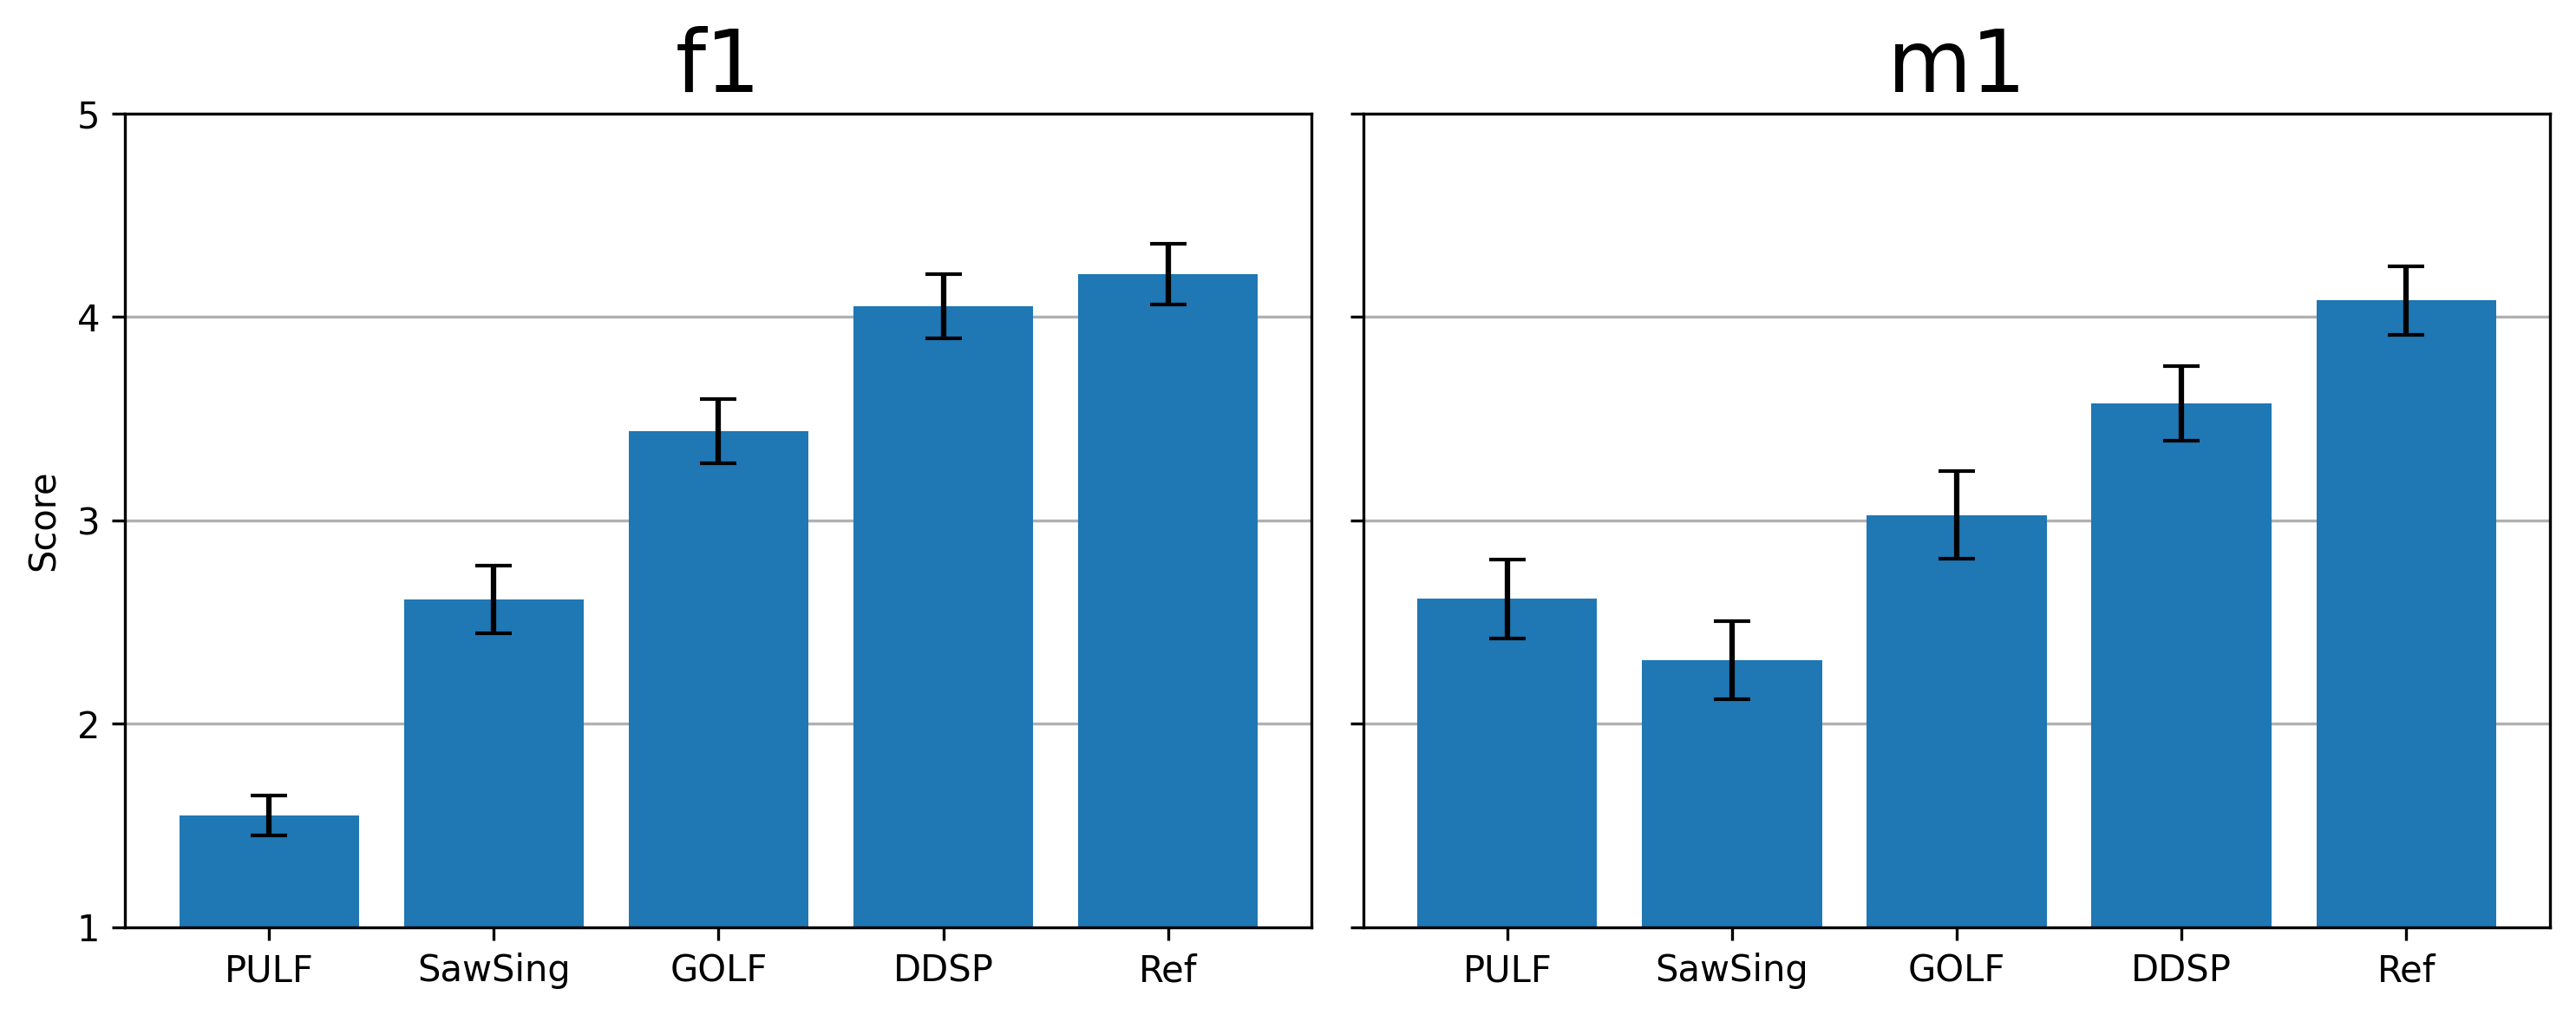

In [5]:
# using the last axis as the likert scale, calculate the MOS mean and 95% confidence interval
mos_mean = np.mean(raw_data, axis=-1)
mos_std = np.std(raw_data, axis=-1)
mos_ci = 1.96 * mos_std / np.sqrt(raw_data.shape[-1])

print(mos_mean, mos_ci)
sort_idx = np.argsort(mos_mean.mean(axis=0))
plt_names = [idx1_name[i] for i in sort_idx]
plt_mean = mos_mean[:, sort_idx]
plt_ci = mos_ci[:, sort_idx]

display_dict = {
    "gt": "Ref",
    "ddsp": "DDSP",
    "sawsing": "SawSing",
    "glottal_d": "GOLF",
    "pulse": "PULF",
}

# plot the result using different color for each likert scale
# sort the data by the mean of the first likert scale
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True, dpi=300)
plt.rc("axes", titlesize=24)
plt.rc('axes', labelsize=20)
plt.rc('ytick', labelsize=16)
plt.rc('xtick', labelsize=18)
for i in range(2):
    ax[i].bar([display_dict[x] for x in plt_names], plt_mean[i], yerr=plt_ci[i],  align='center', ecolor='black', capsize=5)
    ax[i].set_title(f"{idx0_name[i]}")
    ax[i].set_ylim(ymin=1, ymax=5)
    if i == 0:
        ax[i].set_ylabel("Score")
    # ax[i].set_xlabel("Models")
    ax[i].grid(axis="y")
    ax[i].set_axisbelow(True)
plt.tight_layout()
plt.show()

## ANOVA

In [6]:
# do anova test for all the combinations and store them into a confusion matrix
results = np.zeros((2, 5, 5))
for i, j, k in np.ndindex(results.shape):
    if j < k:
        results[i, j, k] = stats.f_oneway(raw_data[i, j], raw_data[i, k])[1]

print(results.min(), results.max())
print(results[0])

0.0 0.14979945174550055
[[0.00000000e+00 1.49799452e-01 5.18067178e-31 5.83851577e-11
  3.72833914e-72]
 [0.00000000e+00 0.00000000e+00 8.65331355e-26 2.55990801e-07
  2.98458516e-65]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.53890209e-11
  3.02067618e-21]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  3.64408583e-48]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]]


## Paired t-test

In [15]:
print(stats.ttest_rel(raw_data[0, 0], raw_data[0, 1]))
print(stats.ttest_rel(raw_data[1, 0], raw_data[1, 1]))

Ttest_relResult(statistic=1.5786464580482067, pvalue=0.11774129420067447)
Ttest_relResult(statistic=4.023028670737778, pvalue=0.00011532439635461517)


## Wilcoxon

In [34]:
print(stats.wilcoxon(raw_data[0, 2], raw_data[0, 4], alternative="less"))
print(stats.wilcoxon(raw_data[1, 2], raw_data[1, 4], alternative="less"))

WilcoxonResult(statistic=4346.5, pvalue=0.9999999999999992)
WilcoxonResult(statistic=1620.0, pvalue=0.021640322899261478)
